In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
!pip install catboost
!pip install category_encoders
#!pip install feature_engine
#!pip install featuretools
#!pip install woodwork

import lightgbm as lgb
import xgboost as xgb
from catboost import *
import catboost as ctb
from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
from category_encoders.target_encoder import TargetEncoder
#from feature_engine.encoding import WoEEncoder
#import featuretools as ft
#from woodwork.logical_types import Categorical

In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [7]:
concat_data = pd.concat([train,test],axis=0)

concat_data = concat_data.fillna("NAN")

city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

In [8]:
for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [9]:
concat_data["credit_limit"] = concat_data["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["per_capita_income_zipcode"] = concat_data["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["yearly_income_person"] = concat_data["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["total_debt"] = concat_data["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [10]:
concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]

In [11]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [12]:
amount_user_mean = train_df.groupby("user_id")["amount"].mean().to_dict()
train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [13]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [14]:
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))

user_id
card_id
errors?
merchant_id
merchant_city
merchant_state


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


mcc
use_chip
card_brand
card_type
has_chip
gender
city
state
birth_month


In [15]:
train_df[target] = train_df[target].astype(float)
corr_list = [target] + numerical_features + [f"{col}_woe" for col in categorical_features if col not in "merchant_id"] + ["diff_amount", "amount_mean"]
train_df[corr_list].corr()

,is_fraud?,amount,cards_issued,credit_limit,current_age,retirement_age,birth_year,latitude,longitude,per_capita_income_zipcode,...,use_chip_woe,card_brand_woe,card_type_woe,has_chip_woe,gender_woe,city_woe,state_woe,birth_month_woe,diff_amount,amount_mean
is_fraud?,1.000000,0.149597,-0.007397,-0.025715,-1.293722e-02,-1.767451e-02,1.343035e-02,1.110763e-02,2.455224e-03,-1.910162e-02,...,0.225278,0.030054,0.024515,0.023347,1.718270e-02,9.122139e-02,4.238608e-02,4.611272e-02,1.580650e-01,-1.643982e-02
amount,0.149597,1.000000,-0.037866,0.084524,2.313861e-02,-3.010743e-02,-2.304187e-02,-2.820779e-03,-4.132371e-02,1.547977e-01,...,0.083184,0.010130,0.001320,0.012968,-1.973489e-02,-2.253464e-02,-5.641419e-02,-5.083988e-02,9.712044e-01,2.382478e-01
cards_issued,-0.007397,-0.037866,1.000000,-0.064020,-4.452398e-02,-1.809705e-02,4.397551e-02,6.063400e-02,-2.394917e-02,-5.224915e-03,...,-0.017527,-0.072797,0.013158,0.015306,-7.593239e-02,1.362764e-02,-2.117442e-02,2.932613e-02,-2.971864e-02,-3.779098e-02
credit_limit,-0.025715,0.084524,-0.064020,1.000000,-8.035226e-02,6.515193e-03,8.095576e-02,9.285560e-02,-7.388929e-02,4.400206e-01,...,0.006417,-0.141868,-0.459051,-0.034776,1.543861e-02,-3.262422e-02,4.399991e-02,-5.550532e-02,1.755220e-02,2.832226e-01
current_age,-0.012937,0.023139,-0.044524,-0.080352,1.000000e+00,1.948660e-02,-9.997259e-01,-1.241548e-01,3.179932e-02,-8.371600e-03,...,-0.000593,-0.099158,0.057243,-0.020377,-4.432176e-02,-1.499338e-01,-1.205216e-01,3.451694e-02,2.424547e-09,9.711994e-02
retirement_age,-0.017675,-0.030107,-0.018097,0.006515,1.948660e-02,1.000000e+00,-2.124429e-02,6.156376e-02,7.915272e-02,-1.191592e-01,...,0.008893,-0.023159,-0.025785,-0.031450,-1.911920e-02,-1.770961e-01,-3.497410e-02,7.625623e-03,-6.643947e-10,-1.263703e-01
birth_year,0.013430,-0.023042,0.043976,0.080956,-9.997259e-01,-2.124429e-02,1.000000e+00,1.249703e-01,-2.948737e-02,5.640238e-03,...,0.001345,0.100585,-0.058511,0.019226,4.441595e-02,1.525214e-01,1.245887e-01,-2.517494e-02,-2.437178e-09,-9.671389e-02
latitude,0.011108,-0.002821,0.060634,0.092856,-1.241548e-01,6.156376e-02,1.249703e-01,1.000000e+00,3.850207e-02,7.869494e-02,...,-0.008528,-0.021290,-0.076998,-0.052635,1.272497e-01,1.337622e-01,2.694811e-01,6.987778e-02,-1.214072e-09,-1.183968e-02
longitude,0.002455,-0.041324,-0.023949,-0.073889,3.179932e-02,7.915272e-02,-2.948737e-02,3.850207e-02,1.000000e+00,-2.289462e-01,...,-0.003158,0.057189,-0.054855,0.053170,-2.471657e-02,2.444905e-02,4.881645e-02,6.157512e-03,1.639091e-09,-1.734485e-01
per_capita_income_zipcode,-0.019102,0.154798,-0.005225,0.440021,-8.371600e-03,-1.191592e-01,5.640238e-03,7.869494e-02,-2.289462e-01,1.000000e+00,...,0.014517,-0.073518,-0.061816,-0.039089,-2.671464e-02,-1.402008e-01,-7.465622e-02,-1.888632e-01,3.661783e-09,6.497340e-01


In [16]:
def get_target_encoder(train, valid, test):
  mean_enc = TargetEncoder(
    cols=categorical_features, min_samples_leaf=25, smoothing=1.0
  )
  mean_enc.fit(valid[categorical_features], valid[target])
  X_train_enc = mean_enc.transform(train[categorical_features])
  X_valid_enc = mean_enc.transform(valid[categorical_features])
  X_test_enc = mean_enc.transform(test[categorical_features])
  X_train_enc = X_train_enc.add_prefix('trg_')
  X_valid_enc = X_valid_enc.add_prefix('trg_')
  X_test_enc = X_test_enc.add_prefix('trg_')
  train = pd.concat([train,X_train_enc], axis=1)
  valid = pd.concat([valid,X_valid_enc], axis=1)
  test = pd.concat([test,X_test_enc], axis=1)
  return train, valid, test

In [17]:
class CFG:
  debug=False
  ver=34
  model="lightgbm"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200

In [18]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [19]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [ ]:
params = {
        'objective': 'binary',
        #'metric': 'logloss',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        "n_estimators":2000,
    }

features = numerical_features + categorical_features + [f"{col}_woe" for col in categorical_features if col not in "merchant_id"] + ["amount_mean", "diff_amount"]
oof_df = pd.DataFrame()
test_preds = []

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    #train_folds, valid_folds, test_folds = get_target_encoder(train_folds, valid_folds, test_df)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_df[features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    model = lgb.LGBMClassifier(**params)
    model.fit(train_X, train_labels,
            eval_set=[(valid_X, valid_labels)],
            eval_metric="log_loss",
            callbacks=[
            lgb.early_stopping(stopping_rounds=CFG.early_stopping_round, verbose=True),
            lgb.log_evaluation(CFG.verbose),
        ],
            categorical_feature=categorical_features
            )

    valid_folds["pred"] = model.predict_proba(valid_X)[:, 1]
    test_pred  = model.predict_proba(test_X)[:, 1]
    test_preds.append(test_pred)
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")
    del model, train_folds, valid_folds, train_X, valid_X, test_X, validy_pred, test_pred

===============  FOLD : 0  ===============
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10289
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 45
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] [binary:BoostFromS

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:288: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.175097
[400]	valid_0's binary_logloss: 0.150956
[600]	valid_0's binary_logloss: 0.14375
[800]	valid_0's binary_logloss: 0.136858
[1000]	valid_0's binary_logloss: 0.134791
[1200]	valid_0's binary_logloss: 0.133703
[1400]	valid_0's binary_logloss: 0.132878
[1600]	valid_0's binary_logloss: 0.132275
[1800]	valid_0's binary_logloss: 0.13212
[2000]	valid_0's binary_logloss: 0.131787
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
F1 Score : 0.6250839650705305
===============  FOLD : 1  ===============
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be i

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:288: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.175249
[400]	valid_0's binary_logloss: 0.151683
[600]	valid_0's binary_logloss: 0.144293
[800]	valid_0's binary_logloss: 0.137523
[1000]	valid_0's binary_logloss: 0.135194
[1200]	valid_0's binary_logloss: 0.133849
[1400]	valid_0's binary_logloss: 0.133239
[1600]	valid_0's binary_logloss: 0.132544
[1800]	valid_0's binary_logloss: 0.132153
[2000]	valid_0's binary_logloss: 0.132056
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
F1 Score : 0.6294974438120962
===============  FOLD : 2  ===============
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:288: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.175348
[400]	valid_0's binary_logloss: 0.151379
[600]	valid_0's binary_logloss: 0.144091
[800]	valid_0's binary_logloss: 0.13686
[1000]	valid_0's binary_logloss: 0.134704
[1200]	valid_0's binary_logloss: 0.133417
[1400]	valid_0's binary_logloss: 0.132482
[1600]	valid_0's binary_logloss: 0.131731
[1800]	valid_0's binary_logloss: 0.131533
[2000]	valid_0's binary_logloss: 0.131235
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
F1 Score : 0.6255869669381888
===============  FOLD : 3  ===============
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be 

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:288: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.175229
[400]	valid_0's binary_logloss: 0.151908
[600]	valid_0's binary_logloss: 0.144515
[800]	valid_0's binary_logloss: 0.137713
[1000]	valid_0's binary_logloss: 0.135894
[1200]	valid_0's binary_logloss: 0.134755
[1400]	valid_0's binary_logloss: 0.133836
[1600]	valid_0's binary_logloss: 0.133075
[1800]	valid_0's binary_logloss: 0.132822
[2000]	valid_0's binary_logloss: 0.132476
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
F1 Score : 0.6307457562464238
===============  FOLD : 4  ===============
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:288: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[200]	valid_0's binary_logloss: 0.175657
[400]	valid_0's binary_logloss: 0.152528
[600]	valid_0's binary_logloss: 0.145429
[800]	valid_0's binary_logloss: 0.138696
[1000]	valid_0's binary_logloss: 0.136631
[1200]	valid_0's binary_logloss: 0.135387
[1400]	valid_0's binary_logloss: 0.134491
[1600]	valid_0's binary_logloss: 0.133857
[1800]	valid_0's binary_logloss: 0.133602
[2000]	valid_0's binary_logloss: 0.133386
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
F1 Score : 0.6248310484649546


In [ ]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.6271534753298635


In [ ]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.5924920023503297
F1 score at threshold 0.16 is 0.6009099816124659
F1 score at threshold 0.17 is 0.6082488428476968
F1 score at threshold 0.18 is 0.6147989397101122
F1 score at threshold 0.19 is 0.6205424735756824
F1 score at threshold 0.2 is 0.6266533419552054
F1 score at threshold 0.21 is 0.6309897937804914
F1 score at threshold 0.22 is 0.6341730558598029
F1 score at threshold 0.23 is 0.6373327565429656
F1 score at threshold 0.24 is 0.6408311655749522
F1 score at threshold 0.25 is 0.6430748714040769
F1 score at threshold 0.26 is 0.6448004885339162
F1 score at threshold 0.27 is 0.6461923652207843
F1 score at threshold 0.28 is 0.6472152896361487
F1 score at threshold 0.29 is 0.6485778256903558
F1 score at threshold 0.3 is 0.6491586780183684
F1 score at threshold 0.31 is 0.6500693903801239
F1 score at threshold 0.32 is 0.649824057941307
F1 score at threshold 0.33 is 0.6494518375508516
F1 score at threshold 0.34 is 0.6489944202054616
F1 score at threshold 0

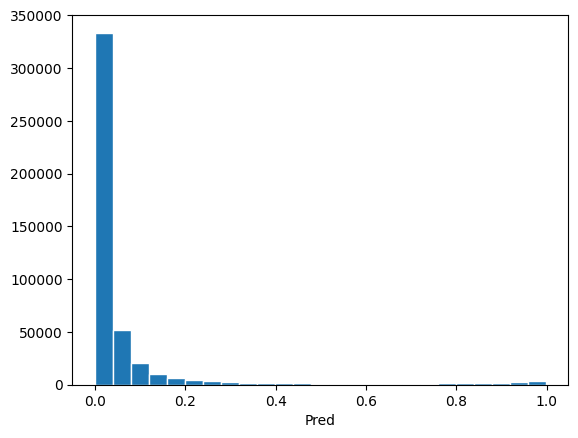

,index,is_fraud?
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    431928
1     26030
Name: is_fraud?, dtype: int64

In [ ]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
submit.columns = ["index","pred"]
pred = np.mean(test_preds, axis=0)
submit['pred'] = pred
submit[CFG.target] = (pred>best_thresh).astype(int)
submit["pred034_fold0"] = test_preds[0]
submit["pred034_fold1"] = test_preds[1]
submit["pred034_fold2"] = test_preds[2]
submit["pred034_fold3"] = test_preds[3]
submit["pred034_fold4"] = test_preds[4]


submit[["index","is_fraud?"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)


plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit[["index","is_fraud?"]])
display(submit[CFG.target].value_counts())

In [ ]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

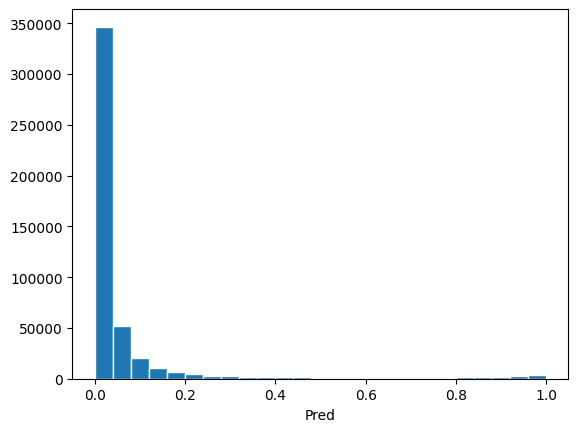

In [ ]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [ ]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)


submit.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False)
display(submit.head())

,index,pred,is_fraud?,pred034_fold0,pred034_fold1,pred034_fold2,pred034_fold3,pred034_fold4
0,471283,0.012772,0,0.008485,0.016370,0.017230,0.007486,0.014286
1,471284,0.136831,0,0.149767,0.063385,0.203358,0.162040,0.105607
2,471285,0.041529,0,0.061520,0.042606,0.035807,0.038882,0.028832
3,471286,0.663704,1,0.755064,0.620680,0.492660,0.715820,0.734295
4,471287,0.002236,0,0.002453,0.002507,0.002382,0.001734,0.002108
